<font color='black'>
Content:

1. [DATA PREPARATION](#1) 
2. [CNN](#2)
3. [MODEL EVALUATION](#3)
4. [PREDICTION AND SUBMITION](#4)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
np.random.seed(45)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

<a id="1"></a><br>
# DATA PREPARATION

In [3]:
# Load the data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.head()
print(train.shape)

(42000, 785)


In [5]:
test.head()
print(test.shape)

(28000, 784)


In [6]:
sns.set(style='white', context='notebook', palette='deep')

In [7]:
# put labels into y_train variable
Y = train["label"]
# Drop 'label' column
X = train.drop(labels = ["label"],axis = 1) 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

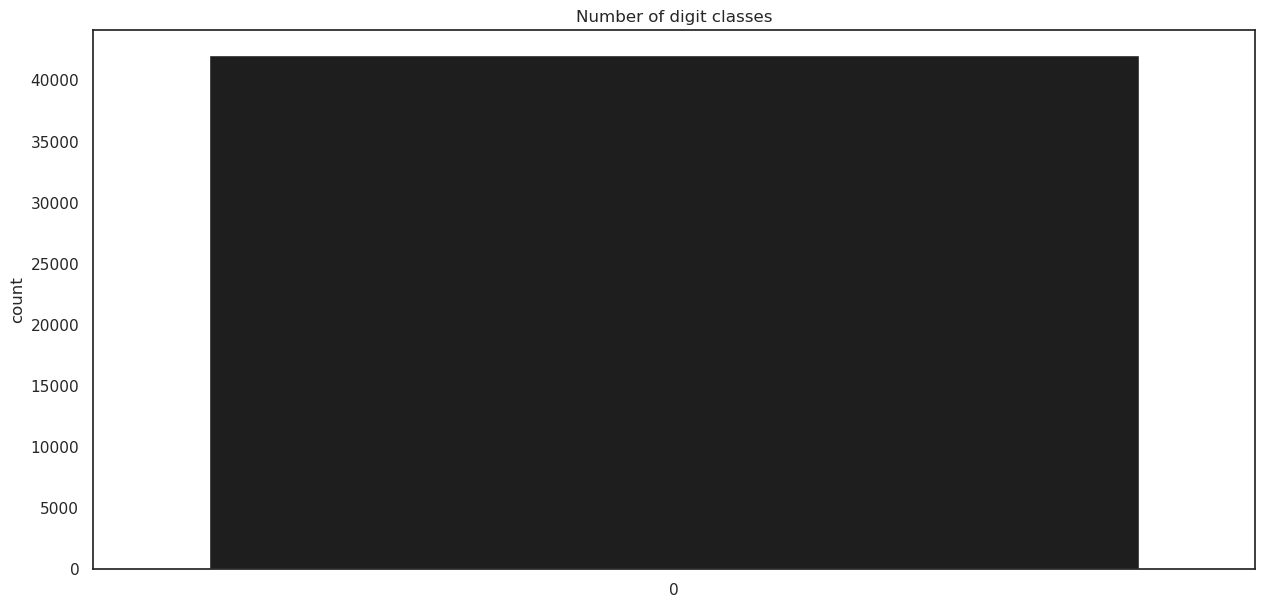

In [8]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y, palette="icefire")
plt.title("Number of digit classes")
Y.value_counts()

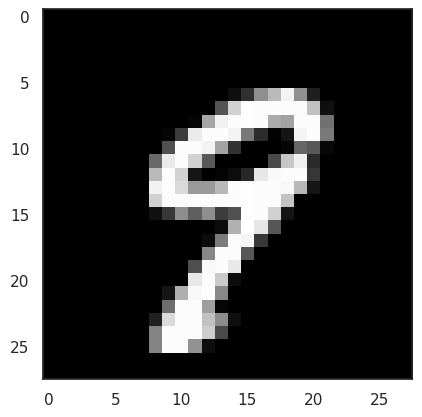

Label: 9


In [9]:
plt.imshow(X.values[11].reshape(28,28),cmap='gray')
plt.show()
print('Label: {}'.format(Y[11]))

In [10]:
# Normalize the data
X = X / 255.0
test = test / 255.0
print("X Shape: ",X.shape)
print("Test Shape: ",test.shape)

X Shape:  (42000, 784)
Test Shape:  (28000, 784)


In [15]:
# Reshape
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [12]:
# Label Encoding 
Y = to_categorical(Y, num_classes = 10)

In [13]:
Y[11]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [16]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.1, random_state=45)
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


<a id="2"></a><br>
# CNN

In [17]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
    
model.add(Dense(10,activation="softmax"))
    


In [18]:

optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                        

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [21]:
epochs = 100
batch_size = 128
es = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [22]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size, 
                              callbacks=es)

Epoch 1/100
295/295 [==============================] - 50s 166ms/step - loss: 0.4655 - accuracy: 0.8528 - val_loss: 3.6200 - val_accuracy: 0.1697
Epoch 2/100
295/295 [==============================] - 49s 165ms/step - loss: 0.1864 - accuracy: 0.9442 - val_loss: 0.4656 - val_accuracy: 0.8440
Epoch 3/100
295/295 [==============================] - 48s 164ms/step - loss: 0.1484 - accuracy: 0.9554 - val_loss: 0.1023 - val_accuracy: 0.9670
Epoch 4/100
295/295 [==============================] - 49s 165ms/step - loss: 0.1259 - accuracy: 0.9627 - val_loss: 0.1015 - val_accuracy: 0.9690
Epoch 5/100
295/295 [==============================] - 49s 166ms/step - loss: 0.1196 - accuracy: 0.9644 - val_loss: 0.1023 - val_accuracy: 0.9688
Epoch 6/100
295/295 [==============================] - 49s 166ms/step - loss: 0.1113 - accuracy: 0.9675 - val_loss: 0.0887 - val_accuracy: 0.9734
Epoch 7/100
295/295 [==============================] - 49s 167ms/step - loss: 0.0985 - accuracy: 0.9708 - val_loss: 0.0820 -

<a id="3"></a><br>
# MODEL EVALUATION

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


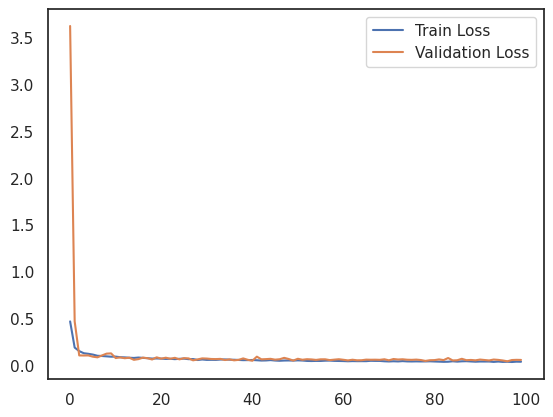

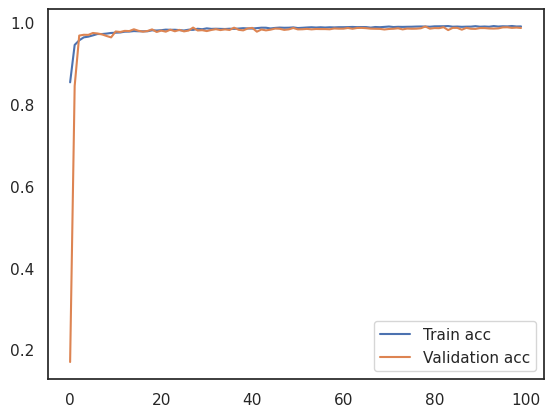

In [23]:
#model evaluation
print(history.history.keys())
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history["accuracy"],label="Train acc")
plt.plot(history.history["val_accuracy"],label="Validation acc")
plt.legend()
plt.show()

132/132 [==============================] - 1s 10ms/step


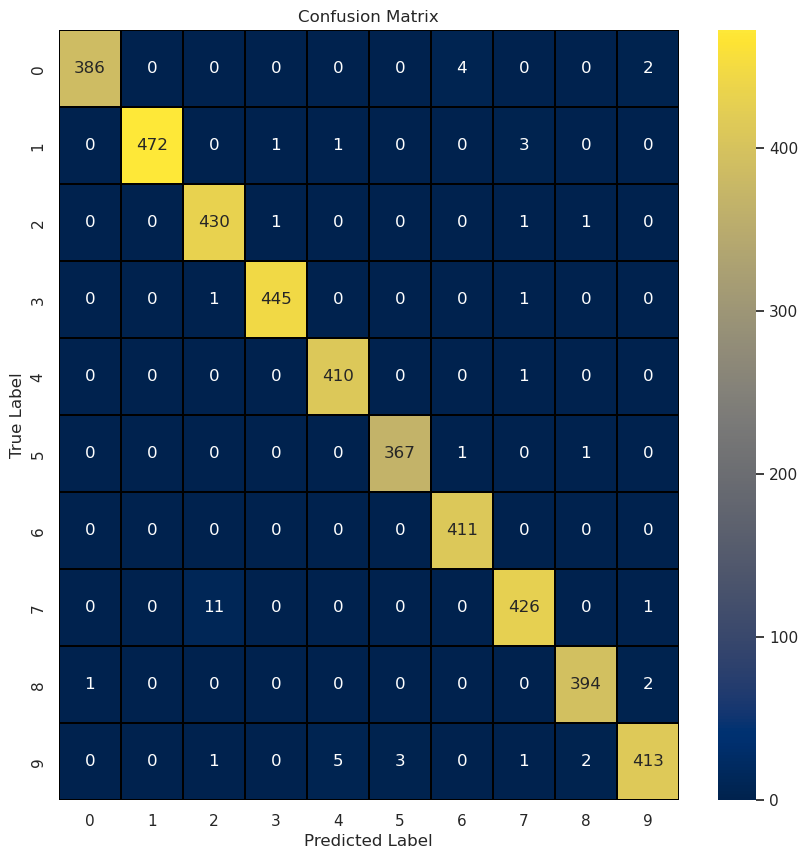

In [24]:
Y_true = np.argmax(y_test, axis=1)

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)

# Şekil (figure) ve eksen (axis) nesnesini al
f, ax = plt.subplots(figsize=(10, 10))

# Isı haritasını çiz
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap="cividis", linecolor="black", fmt='.0f', ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
for i in range(len(confusionMatrix)):
    print("Class:",str(i))
    print("Number of Wrong Prediction:", str(sum(confusionMatrix[i])-confusionMatrix[i][i]), "out of 1000")
    print("Percentage of True Prediction: {:.2f}%".format(confusionMatrix[i][i] / 10))
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

Class: 0
Number of Wrong Prediction: 6 out of 1000
Percentage of True Prediction: 38.60%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 1
Number of Wrong Prediction: 5 out of 1000
Percentage of True Prediction: 47.20%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 2
Number of Wrong Prediction: 3 out of 1000
Percentage of True Prediction: 43.00%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 3
Number of Wrong Prediction: 2 out of 1000
Percentage of True Prediction: 44.50%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 4
Number of Wrong Prediction: 1 out of 1000
Percentage of True Prediction: 41.00%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 5
Number of Wrong Prediction: 2 out of 1000
Percentage of True Prediction: 36.70%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 6
Number of Wrong Prediction: 0 out of 1000
Percentage of True Prediction: 41.10%
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 7
Number of Wrong Prediction: 12 out of 1000
Percentage of True Prediction: 42.60%
<<<<<<<<<<<<<<<<<<<<<

132/132 [==============================] - 1s 11ms/step


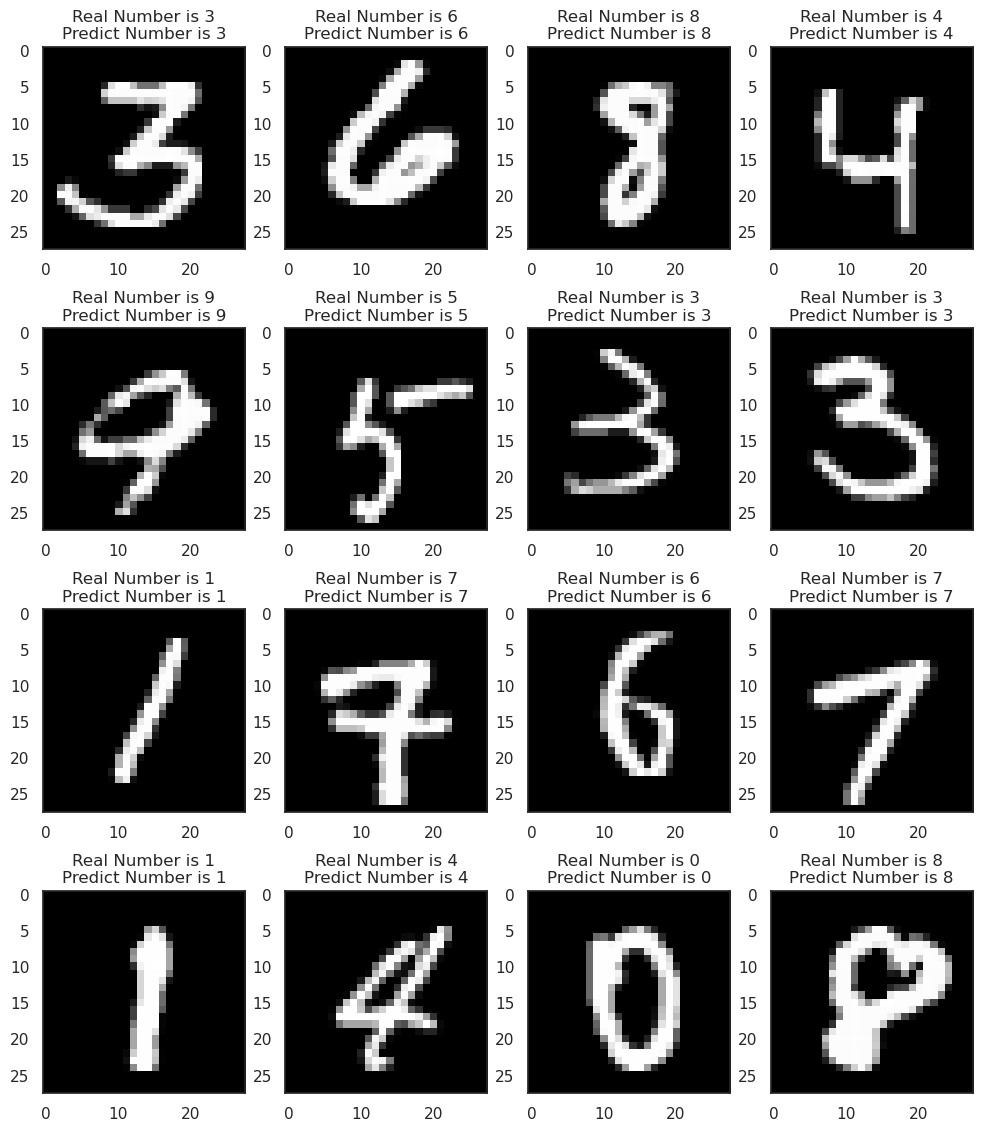

In [26]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='gray')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

<a id="4"></a><br>
# PREDICTION AND SUBMITION

In [27]:
# predict test data
predict = model.predict(test, verbose=1)
predict = np.argmax(predict, axis=1)

875/875 [==============================] - 9s 11ms/step


In [28]:
sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [29]:
# submissions
sub['Label'] = predict
sub.to_csv("CNN989_submit.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
